# Implementation of an Autoencoder (AE)
#### based on PyTorch tutorial https://pytorch.org/tutorials/beginner/basics/intro.html , https://www.cs.toronto.edu/~lczhang/360/lec/w05/autoencoder.html and https://github.com/patrickloeber/pytorch-examples/blob/master/Autoencoder.ipynb
## Simple linear AE with one layer into hidden (latent) space 748 -> 256 -> 12 and back 12 -> 256 -> 748

#### Build for MINST datasets

###### ***For sc-RNAseq:*** fix enable cuda/GPU (only needed if CPU is to slow), try different optimiser, check for loss function, trying learning rates, nn.ReLU() function may not be the best, checking for overfitting by plotting loss of model and training data, Batch size has to be optimised: https://arxiv.org/abs/1609.04836 , https://arxiv.org/abs/1703.04933 . Maybe we should try a program like https://opendatascience.com/optimizing-pytorch-performance-batch-size-with-pytorch-profiler/ for that on a later stage for performance (not sure if the data will be to large in the future)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor

In [2]:
batch_size = 64

transform = transforms.ToTensor()

mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_dataloader = DataLoader(dataset=mnist_data,batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(dataset=mnist_data,batch_size=batch_size, shuffle=True)

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"   ### needed if Nvidia GPU is available and wanted to use the GPU
print(f"Using {device} device")

Using cuda device


In [4]:
### Building the neural network structure ####
dim_encoder_decoder = 28 * 28

class linear_AE(nn.Module):
    def __init__(self):
        super(linear_AE, self).__init__()

        self.encoder = nn.Sequential(             # sequential operation of the following code:
            nn.Linear(dim_encoder_decoder, 256),  #### data into the neural network layer (28*28 pixel -> 256 nodes)
            nn.ReLU(),                            #### ReLU(x) = (x)^(+) = max(0,x) 
            nn.Linear(256, 12)
        )
        
        self.decoder = nn.Sequential(             # sequential operation of the following code:
            nn.Linear(12, 256),                   #### decoding laten layer (12 -> 256 nodes)
            nn.ReLU(),      #### 
            nn.Linear(256, dim_encoder_decoder),  #### reconstruction of image (256 -> 748)
            nn.Sigmoid()
        )
        
    def forward(self, x):                         # exicute the endcoder and decoder defined in __init__(self)
        
        endoded = self.encoder(x) 
        decoded = self.decoder(endoded) 
        return decoded
        
model = linear_AE().to(device) #### this is needed for cuda
print(model)

linear_AE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=12, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=12, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=784, bias=True)
    (3): Sigmoid()
  )
)


In [5]:
loss_fn = nn.MSELoss() ###   .CrossEntropyLoss() #           ### nn.MSELoss() (Mean Square Error) for regression tasks

optimizer = torch.optim.Adam(model.parameters(),lr=1e-3, weight_decay=1e-5)

Epoch:1, Loss:0.0252 ; Train Loss:0.0183
Epoch:2, Loss:0.0163 ; Train Loss:0.0177
Epoch:3, Loss:0.0169 ; Train Loss:0.0170
Epoch:4, Loss:0.0171 ; Train Loss:0.0184
Epoch:5, Loss:0.0155 ; Train Loss:0.0162
Epoch:6, Loss:0.0187 ; Train Loss:0.0158
Epoch:7, Loss:0.0172 ; Train Loss:0.0128
Epoch:8, Loss:0.0137 ; Train Loss:0.0143
Epoch:9, Loss:0.0147 ; Train Loss:0.0168
Epoch:10, Loss:0.0151 ; Train Loss:0.0121
Epoch:11, Loss:0.0154 ; Train Loss:0.0163
Epoch:12, Loss:0.0137 ; Train Loss:0.0168
Epoch:13, Loss:0.0118 ; Train Loss:0.0153
Epoch:14, Loss:0.0156 ; Train Loss:0.0174
Epoch:15, Loss:0.0119 ; Train Loss:0.0145
Epoch:16, Loss:0.0158 ; Train Loss:0.0133
Epoch:17, Loss:0.0149 ; Train Loss:0.0143
Epoch:18, Loss:0.0133 ; Train Loss:0.0129
Epoch:19, Loss:0.0109 ; Train Loss:0.0142
Epoch:20, Loss:0.0157 ; Train Loss:0.0152
Epoch:21, Loss:0.0143 ; Train Loss:0.0149
Epoch:22, Loss:0.0130 ; Train Loss:0.0146
Epoch:23, Loss:0.0136 ; Train Loss:0.0149
Epoch:24, Loss:0.0144 ; Train Loss:0.0129
E

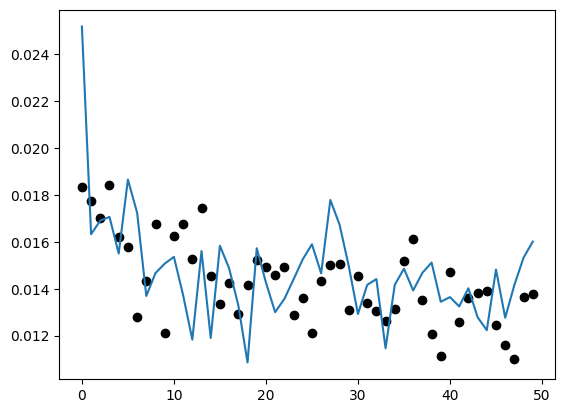

In [6]:
num_epochs = 50
outputs = []
torch.manual_seed(42)
for epoch in range(num_epochs):
    for (X, label) in train_dataloader:
        X = X.reshape(-1, 28*28).to(device)
        pred = model(X)
        loss = loss_fn(pred,X)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}', end="")
    outputs.append([epoch, loss.item()])
    
    for (X_test, label) in test_dataloader:
        X_test = X_test.reshape(-1, 28*28).to(device)
        pred_test = model(X_test)
        loss_test = loss_fn(pred_test, X_test)
    print(f' ; Train Loss:{loss_test.item():.4f}')
    plt.scatter(epoch, loss_test.item(), c="black")
    
plt.plot([i[0] for i in outputs], [i[1] for i in outputs])
plt.show()

In [7]:
torch.save(model, 'model_oneLayer_AE.pth')

In [8]:
model = torch.load('model_oneLayer_AE.pth')

In [9]:
model

linear_AE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=12, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=12, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=784, bias=True)
    (3): Sigmoid()
  )
)